# Preprocessing for DE analysis

In [1]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
import yaml
import argparse

import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the path to import from sibling directory
sys.path.append(os.path.abspath('../'))
from utils import feature_selection, _convert_oak_path


In [5]:
config = 'DE_config_CD4iR1_Psomagen.yaml'
# Load configuration from YAML file
with open(config, 'r') as config_file:
    config = yaml.safe_load(config_file)

# Extract parameters from config
datadir = _convert_oak_path(config['datadir'])
experiment_name = config['experiment_name']
datadir = f'{datadir}/{experiment_name}'

# Get parameters with defaults
min_replicates = config.get('min_replicates', 3)
min_cells_per_guide = config.get('min_cells_per_guide', 5)
n_hvgs = config.get('n_hvgs', 10000)
chunk_size = config.get('chunk_size', 50)
chunk_split_seed = config.get('chunk_split_seed', 1423)

# Feature selection parameters
feature_selection_params = config.get('feature_selection', {})
highx_min_mean_counts = feature_selection_params.get('highx_min_mean_counts', 2000)
highx_min_pct_dropouts = feature_selection_params.get('highx_min_pct_dropouts', 0.5)
lowx_max_pct_dropouts = feature_selection_params.get('lowx_max_pct_dropouts', 99.9)
lowx_min_counts = feature_selection_params.get('lowx_min_counts', 99.9)

# File paths
file_paths = config.get('file_paths', {})
pseudobulk_file = f"{experiment_name}_merged.DE_pseudobulk.h5ad"
no_effect_guides_file = file_paths.get('no_effect_guides_file', 'no_effect_guides.txt')
de_test_genes_file = file_paths.get('de_test_genes_file', 'DE_test_genes.txt')
target2chunk_file = file_paths.get('target2chunk_file', 'DE_target2chunk.csv.gz')


In [56]:
datadir

'/mnt/oak/users/emma/data/GWT//CD4iR1_Psomagen'

## Merge pseudobulk objects

In [105]:
# Find all pseudobulk files
pseudobulk_files = glob.glob(f"{datadir}/tmp/*.postQC.DE_pseudobulk.h5ad")
print(f"Found {len(pseudobulk_files)} pseudobulk files")
sample2files = {}
for f in pseudobulk_files:
    sample_id = os.path.basename(f).split('.')[0]
    if sample_id not in sample2files:
        sample2files[sample_id] = []
    sample2files[sample_id].append(f)

Found 92 pseudobulk files


In [106]:
from tqdm.notebook import tqdm

def merge_pseudobulks(h5ad_files, sample_cols = ['cell_sample_id', 'guide_id']):
    # Get var table for all genes
    all_vars = [anndata.experimental.read_lazy(a).var.to_dataframe().copy() for a in h5ad_files]
    var_merged = pd.concat(all_vars)[['gene_ids', 'gene_name']].drop_duplicates()

    all_obs = []
    keep_cols = ['10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition',
        'guide_id', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type']
    for a in h5ad_files:
        a_obs = anndata.experimental.read_lazy(a).obs.to_dataframe()[keep_cols]
        a_obs["sample_id"] = a_obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
        all_obs.append(a_obs)
    obs_merged = pd.concat(all_obs).drop_duplicates()
    obs_merged = obs_merged.set_index('sample_id')

    # Read and sum pseudobulks
    merged_adata = sc.read_h5ad(h5ad_files[0])
    merged_adata.obs["sample_id"] = merged_adata.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
    n_cells_merged = merged_adata.obs[['sample_id', 'n_cells']].set_index('sample_id')

    for f in tqdm(h5ad_files[1:], desc="Merging pseudobulk files"):
        a = sc.read_h5ad(f)
        a.obs["sample_id"] = a.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
        # Keep track of n_cells
        n_cells_a = a.obs[['sample_id', 'n_cells']].set_index('sample_id')
        all_indices = n_cells_merged.index.union(n_cells_a.index)
        n_cells_merged = n_cells_merged.reindex(all_indices).fillna(0)
        n_cells_a = n_cells_a.reindex(all_indices).fillna(0)
        n_cells_merged = n_cells_merged + n_cells_a
        merged_adata = anndata.concat([merged_adata, a], join='outer')
        merged_adata = sc.get.aggregate(merged_adata, by='sample_id', func='sum', layer='sum')

    merged_adata.var = var_merged.loc[merged_adata.var_names]
    merged_adata.obs = obs_merged.loc[merged_adata.obs_names]
    merged_adata.obs['n_cells'] = n_cells_merged.loc[merged_adata.obs_names]
    return(merged_adata)

In [108]:
for s in sample2files.keys():
    if s != 'CD4i_R1_D2_Rest_CD4i_R1_Ultima':
        print(f'Processing sample {s}')
        pbulk_adata = merge_pseudobulks(sample2files[s])
        pbulk_adata.write_h5ad(f'{datadir}/{experiment_name}_{s}.DE_pseudobulk.h5ad')


Processing sample CD4i_R1_D1_Stim8hr_CD4i_R1_Ultima


Merging pseudobulk files:   0%|          | 0/22 [00:00<?, ?it/s]

Processing sample CD4i_R1_D1_Rest_CD4i_R1_Ultima


Merging pseudobulk files:   0%|          | 0/22 [00:00<?, ?it/s]

Processing sample CD4i_R1_D2_Stim8hr_CD4i_R1_Ultima


Merging pseudobulk files:   0%|          | 0/22 [00:00<?, ?it/s]

Read objects

In [46]:
pbulk_files = glob.glob(f"{datadir}/*.DE_pseudobulk.h5ad")
adatas_ls = []
for f in pbulk_files:
    if not f.endswith(pseudobulk_file):
        adata = sc.read_h5ad(f)
        adatas_ls.append(adata)

pbulk_adata = anndata.concat(adatas_ls, join='outer', fill_value=0)
# Merge all .var tables from adatas in adatas_ls
var_merged = pd.concat([adata.var for adata in adatas_ls]).drop_duplicates()
pbulk_adata.var = var_merged.loc[pbulk_adata.var_names]

In [47]:
pbulk_adata

AnnData object with n_obs × n_vars = 92971 × 18117
    obs: '10xrun_id', 'cell_sample_id', 'donor_id', 'culture_condition', 'guide_id', 'perturbed_gene_name', 'perturbed_gene_id', 'guide_type', 'n_cells'
    var: 'gene_ids', 'gene_name'
    layers: 'sum'

### Get testable genes

/tmp/ipykernel_1640859/321147778.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tot_counts_lower_q = pbulk_adata.obs.groupby('culture_condition')['total_counts'].quantile(config.get('min_counts_quantile', 0.005)).to_dict()


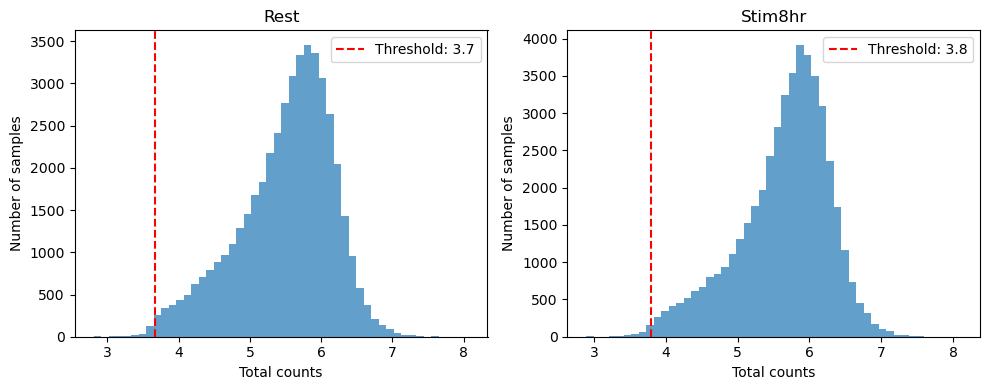

In [48]:
all_conditions = pbulk_adata.obs['culture_condition'].unique() 
pbulk_adata.obs['total_counts'] = np.array(pbulk_adata.layers['sum'].sum(1)).flatten()

# Exclude samples with very low counts compared to others (threshold by condition)
tot_counts_lower_q = pbulk_adata.obs.groupby('culture_condition')['total_counts'].quantile(config.get('min_counts_quantile', 0.005)).to_dict()

# Plot histograms of total counts by condition with threshold lines
fig, axes = plt.subplots(1, len(all_conditions), figsize=(5*len(all_conditions), 4))
if len(all_conditions) == 1:
    axes = [axes]

for ax, condition in zip(axes, all_conditions):
    # Get data for this condition
    mask = pbulk_adata.obs['culture_condition'] == condition
    counts = np.log10(pbulk_adata.obs.loc[mask, 'total_counts'])
    threshold = np.log10(tot_counts_lower_q[condition])
    
    # Plot histogram
    ax.hist(counts, bins=50, alpha=0.7)
    ax.axvline(threshold, color='red', linestyle='--', 
               label=f'Threshold: {threshold:.1f}')
    
    # Customize plot
    ax.set_title(f'{condition}')
    ax.set_xlabel('Total counts')
    ax.set_ylabel('Number of samples')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [49]:
# Load list of ineffective guides
no_effect_guides_file = os.path.join(datadir, 'no_effect_guides.txt')
no_effect_guides = []
try:
    with open(no_effect_guides_file, 'r') as f:
        no_effect_guides = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(no_effect_guides)} ineffective guides from {no_effect_guides_file}")
except FileNotFoundError:
    raise FileNotFoundError(f"No effect guides file not found at {no_effect_guides_file} - run src/1_preprocess/estimate_guide_effect.ipynb")


Loaded 1480 ineffective guides from /mnt/oak/users/emma/data/GWT//CD4iR1_Psomagen/no_effect_guides.txt


In [50]:
# Load info on perturbed genes to test
# Create separate boolean columns for each filtering condition
pbulk_adata.obs['keep_min_cells'] = pbulk_adata.obs['n_cells'] >= config.get('min_cells_per_guide', 5)  # Mark guides with at least n cells per condition & sample
pbulk_adata.obs['keep_effective_guides'] = ~pbulk_adata.obs['guide_id'].isin(no_effect_guides)  # Don't count ineffective guides as useful replicates

# Filter counts outliers
pbulk_adata.obs['keep_total_counts'] = True  # Initialize as all True
for c, thresh in tot_counts_lower_q.items():
    mask = pbulk_adata.obs['culture_condition'] == c
    pbulk_adata.obs.loc[mask, 'keep_total_counts'] = pbulk_adata.obs.loc[mask, 'total_counts'] >= thresh

# Combine all conditions into a single keep_for_DE column
pbulk_adata.obs['keep_for_DE'] = (
    pbulk_adata.obs['keep_min_cells'] & 
    pbulk_adata.obs['keep_effective_guides'] & 
    pbulk_adata.obs['keep_total_counts']
)

In [51]:
guide_cell_counts = pbulk_adata.obs[['guide_id', 'perturbed_gene_name', 'culture_condition', 'n_cells', 'keep_for_DE']]
guide_cell_counts = guide_cell_counts[~guide_cell_counts['guide_id'].str.startswith('NTC-')] 

# Count number of replicates per perturbed gene in each condition
genes_replicates = guide_cell_counts.groupby(['perturbed_gene_name', 'culture_condition'])['keep_for_DE'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='perturbed_gene_name', columns='culture_condition', values='keep_for_DE')\
    .fillna(0)

genes2test = genes_replicates >= min_replicates
genes2test_dict = {col: genes2test.index[genes2test[col]].tolist() for col in genes2test.columns}
for c in genes2test_dict.keys():
    print(c, ':', len(genes2test_dict[c]))

Rest : 8481
Stim8hr : 9047


/tmp/ipykernel_1640859/3090283106.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  genes_replicates = guide_cell_counts.groupby(['perturbed_gene_name', 'culture_condition'])['keep_for_DE'].sum()\


## Filter samples for DE analysis

In [52]:
# Keep genes that pass filters for each condition separately
pbulk_adata.obs['keep_test_genes'] = False  # Initialize as all False

# For each condition, mark genes that pass filters for that condition
for condition, genes in genes2test_dict.items():
    mask = (pbulk_adata.obs['culture_condition'] == condition) & \
           (pbulk_adata.obs['perturbed_gene_name'].isin(genes))
    pbulk_adata.obs.loc[mask, 'keep_test_genes'] = True

# Always keep NTC samples
pbulk_adata.obs.loc[pbulk_adata.obs['perturbed_gene_name'] == 'NTC', 'keep_test_genes'] = True

# Aggregate with the existing keep_for_DE condition
pbulk_adata.obs['keep_for_DE'] = pbulk_adata.obs['keep_for_DE'] & pbulk_adata.obs['keep_test_genes']

pbulk_adata.obs['keep_for_DE'].value_counts()

keep_for_DE
True     68169
False    24802
Name: count, dtype: int64

In [27]:
pbulk_adata.X = pbulk_adata.layers['sum'].copy()
del pbulk_adata.layers['sum']
pbulk_adata.obs['log10_n_cells'] = np.log10(pbulk_adata.obs['n_cells'])
pbulk_adata.write_h5ad(f'{datadir}/{pseudobulk_file}')

In [4]:
try:
    pbulk_adata
except NameError:
    pbulk_adata = sc.read_h5ad(f'{datadir}/{pseudobulk_file}')
pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].copy()

In [9]:
pbulk_adata.var[pbulk_adata.var['gene_name'] == 'IFNG']

,gene_ids,gene_name
ENSG00000111537,ENSG00000111537,IFNG


## Feature selection

In [11]:
feature_selection_vars = pd.DataFrame()
for c in pbulk_adata.obs['culture_condition'].unique():
    print(c)
    pbulk_adata_cond = pbulk_adata[pbulk_adata.obs['culture_condition'] == c].copy()
    feature_selection_var = feature_selection(
        pbulk_adata_cond,
        n_hvgs = n_hvgs,
        subset_adata=False,
        highx_min_mean_counts = highx_min_mean_counts,
        highx_min_pct_dropouts_by_counts = highx_min_pct_dropouts,
        lowx_max_pct_dropouts_by_counts = lowx_max_pct_dropouts,
        lowx_min_counts = lowx_min_counts,
        return_all = True,
        use_rapids = False
        )
    
    # Remove PuroR gene if it exists in the feature selection results
    if 'CUSTOM001_PuroR' in feature_selection_var.index:
        feature_selection_var = feature_selection_var.drop('CUSTOM001_PuroR')

    all_targets = pbulk_adata_cond.obs['perturbed_gene_id'].unique()
    feature_selection_var['is_target'] = feature_selection_var.index.isin(all_targets)

    DE_test_genes = feature_selection_var[feature_selection_var['highly_variable'] | feature_selection_var['is_target']].index.tolist()
    # Save DE_test_genes to a text file
    with open(f"{datadir}/{de_test_genes_file.replace('.txt', f'.{c}.txt')}", 'w') as f:
        for gene in DE_test_genes:
            f.write(f"{gene}\n")
    feature_selection_var['culture_condition'] = c
    feature_selection_vars = pd.concat([feature_selection_vars, feature_selection_var])

Rest
Stim8hr


['ENSG00000121410', 'ENSG00000103591', 'ENSG00000115977', 'ENSG00000087884', 'ENSG00000157426', ..., 'ENSG00000198205', 'ENSG00000198455', 'ENSG00000070476', 'ENSG00000159840', 'ENSG00000074755']
Length: 9048
Categories (9048, object): ['AKAP2', 'ENSG00000000003', 'ENSG00000000419', 'ENSG00000000460', ..., 'SEPT6', 'SGK494', 'SMIM11B', 'U2AF1L5']

In [26]:


highly_expressed_outiers = pbulk_adata_cond.var_names[(pbulk_adata_cond.var['mean_counts'] > highx_min_mean_counts) & (pbulk_adata_cond.var['pct_dropout_by_counts'] < highx_min_pct_dropouts)].tolist()
'ENSG00000111537' in highly_expressed_outiers

True

<Axes: xlabel='donor_id', ylabel='ENSG00000134460'>

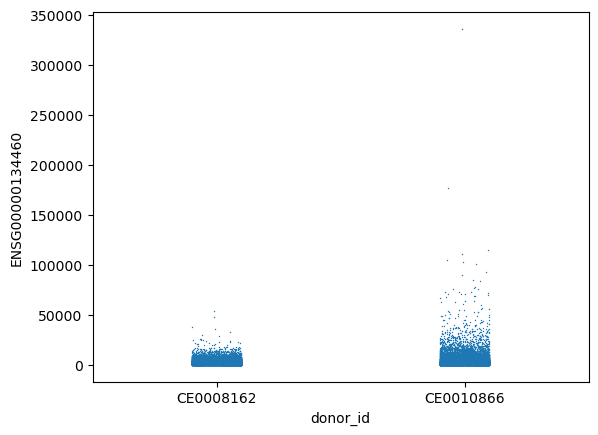

In [50]:
pl_df = sc.get.obs_df(pbulk_adata_cond, ['donor_id','ENSG00000134460'])
sns.stripplot(data=pl_df, x='donor_id', y='ENSG00000134460', s=1)
# plt.plot(pbulk_adata_cond[:, 'ENSG00000111537'].X.toarray(), '.');


In [51]:
pbulk_adata_cond.var[(pbulk_adata_cond.var['mean_counts'] > highx_min_mean_counts) & (pbulk_adata_cond.var['pct_dropout_by_counts'] < highx_min_pct_dropouts)].sort_values('mean_counts')

,gene_ids,gene_name,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts
ENSG00000145912,ENSG00000145912,NHP2,35437,1013.606174,6.922256,0.000000,35919162.0,17.396781
ENSG00000196154,ENSG00000196154,S100A4,35437,1013.822191,6.922469,0.000000,35926817.0,17.396995
ENSG00000165527,ENSG00000165527,ARF6,35437,1029.505432,6.937805,0.000000,36482584.0,17.412346
ENSG00000147168,ENSG00000147168,IL2RG,35437,1031.279200,6.939524,0.000000,36545441.0,17.414067
ENSG00000163600,ENSG00000163600,ICOS,35437,1033.463019,6.941638,0.000000,36622829.0,17.416182
ENSG00000243678,ENSG00000243678,NME2,35437,1045.735587,6.953432,0.000000,37057732.0,17.427988
ENSG00000204264,ENSG00000204264,PSMB8,35437,1051.022857,6.958470,0.000000,37245097.0,17.433031
ENSG00000198899,ENSG00000198899,MT-ATP6,35437,1052.281542,6.959666,0.000000,37289701.0,17.434228
ENSG00000080824,ENSG00000080824,HSP90AA1,35437,1068.040297,6.974517,0.000000,37848144.0,17.449093
ENSG00000165732,ENSG00000165732,DDX21,35437,1076.040974,6.981973,0.000000,38131664.0,17.456556


In [15]:
feature_selection_var[feature_selection_var['gene_name'] == 'IFNG']

,gene_ids,gene_name,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,is_target,culture_condition


In [16]:
## --- SPLIT PERTURBATIONS INTO CHUNKS --- ##
for c in pbulk_adata.obs['culture_condition'].unique():
    print(c)
    pbulk_adata_cond = pbulk_adata[pbulk_adata.obs['culture_condition'] == c].copy()
    all_targets = pbulk_adata_cond.obs['perturbed_gene_id'].unique().tolist()
    all_targets.remove('NTC')

    # Randomize targets before splitting (without replacement)
    np.random.seed(chunk_split_seed)
    np.random.shuffle(all_targets)

    # Split all_targets into groups based on chunk_size
    target_chunks = [all_targets[i:i+chunk_size] for i in range(0, len(all_targets), chunk_size)]

    # Initialize a binary matrix with zeros
    target_chunk_matrix = pd.DataFrame(0, 
                                    index=all_targets, 
                                    columns=[f'chunk_{i}' for i in range(len(target_chunks))])

    # Fill the matrix with 1s for each target in its respective chunk
    for chunk_idx, chunk in enumerate(target_chunks):
        target_chunk_matrix.loc[chunk, f'chunk_{chunk_idx}'] = 1

    target_chunk_matrix.to_csv(f"{datadir}/{target2chunk_file.replace('.csv.gz', f'.{c}.csv.gz')}", compression='gzip')

Rest
Stim8hr


---

Testing DE analysis

In [77]:
all_chunk_outs = glob.glob('/mnt/oak/users/emma/data/GWT//CD4iR1_Psomagen/DE_results_all_confounders/tmp/DE_results.Rest*.csv.gz')
all_res = []
for f in all_chunk_outs:
    res = pd.read_csv(f, compression='gzip')
    if any(res.variable == 'ENSG00000111537'):
        continue
    else:
        print('missing IFNG')
    all_res.append(res)

In [84]:
sgrna_library_metadata = pd.read_csv('../../metadata/sgRNA_library_curated.csv', index_col=0)
gene_name_to_id = dict(zip(sgrna_library_metadata['perturbed_gene_id'], sgrna_library_metadata['perturbed_gene_name']))
var_df = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.DE_pseudobulk.h5ad', backed=True).var.copy()

In [101]:
from merge_DE_results import parse_DE_results_2_adata
from tqdm import tqdm
de_results_dir = '/mnt/oak/users/emma/data/GWT//CD4iR1_Psomagen/DE_results_all_confounders/tmp/'
# Read all csv.gz files from the DE results directory
de_results_files = glob.glob(de_results_dir + 'DE_results.*.csv.gz')
de_results_adatas = []

for file in tqdm(de_results_files, desc="Processing DE result files"):
    try:
        df = pd.read_csv(file, compression='gzip', index_col=0)
        df = df.rename({'contrast': 'target_contrast'}, axis=1)
        df['target_contrast_gene_name'] = df['target_contrast'].map(lambda x: gene_name_to_id.get(x, x))
        de_results_adatas.append(parse_DE_results_2_adata(df))
    except EOFError:
        continue


Processing DE result files: 100%|██████████| 351/351 [07:53<00:00,  1.35s/it]


In [117]:
all_dfs = {}
for stat in ['baseMean', 'log_fc', 'lfcSE', 'p_value','adj_p_value']:
    # Use all_variables to ensure consistent columns across stats
    stat_df = df.pivot(values=stat, columns='variable', index='target_contrast')
    # Reindex to include all variables, filling missing values with NaN
    # stat_df = stat_df.reindex(columns=all_variables)
    all_dfs[stat] = stat_df

DE_anndata = anndata.AnnData(
        layers = all_dfs.copy()
    )

In [123]:
np.isnan(DE_anndata.layers['adj_p_value'])

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [130]:
file = de_results_files[0]
df = pd.read_csv(file, compression='gzip', index_col=0)
df = df.rename({'contrast': 'target_contrast'}, axis=1)

In [136]:
file

'/mnt/oak/users/emma/data/GWT//CD4iR1_Psomagen/DE_results_all_confounders/tmp/DE_results.Stim8hr.chunk_178.csv.gz'

In [129]:
de_results_adatas[6][de_results_adatas[6].var_names == 'ENSG00000111537']

IndexError: Boolean index does not match AnnData’s shape along this dimension. Boolean index has shape (10981,) while AnnData index has shape (50,).

In [124]:
['ENSG00000111537' in x.var_names for x in de_results_adatas]

[False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 T

In [92]:
a = parse_DE_results_2_adata(df)

In [100]:
a[:, a.var_names == 'ENSG00000111537']

View of AnnData object with n_obs × n_vars = 50 × 1
    obs: 'target_contrast_gene_name', 'culture_condition', 'target_contrast'
    layers: 'baseMean', 'log_fc', 'lfcSE', 'p_value', 'adj_p_value'

In [33]:
cond = 'Rest'
chunk_ix = 1

In [ ]:


# # Create directories for results
# de_results_dir = f'{datadir}/DE_results_{run_name}/'
# de_results_tmp_dir = f'{de_results_dir}/tmp/'
# os.makedirs(de_results_dir, exist_ok=True)
# os.makedirs(de_results_tmp_dir, exist_ok=True)

# pbulk_adata = sc.read_h5ad(f'{datadir}/{experiment_name}_merged.DE_pseudobulk.h5ad')
# pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].copy()

# Read list of genes for DE testing
try:
    with open(f'{datadir}/DE_test_genes.{cond}.txt', 'r') as f:
        de_test_genes = [line.strip() for line in f if line.strip()]
    print(f"Loaded {len(de_test_genes)} genes for DE testing")
except FileNotFoundError:
    raise(FileNotFoundError, f"Warning: DE test genes file not found at {datadir}/DE_test_genes.txt - run feature selection first.")

pbulk_adata = pbulk_adata[:, de_test_genes].copy()

# Get targets to test
target_chunk_matrix = pd.read_csv(f'{datadir}/DE_target2chunk.{cond}.csv.gz', compression='gzip', index_col=0)
test_targets = target_chunk_matrix.index[target_chunk_matrix[f'chunk_{chunk_ix}'] == 1].tolist()

Loaded 13076 genes for DE testing


In [37]:
test_targets

50

In [38]:
run_de_params = config.get('run_DE_params', {})
design_formula = run_de_params.get('design_formula', '~ log10_n_cells + target')
min_counts_per_gene = run_de_params.get('min_counts_per_gene', 10)

model, results = ms_perturb_data.run_target_DE(
    design_formula = design_formula,
    test_state = [cond], test_targets=test_targets,
    min_counts_per_gene = min_counts_per_gene,
    return_model = True
    )

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Testing targets:   0%|          | 0/50 [00:00<?, ?it/s]Running Wald tests...
... done in 1.77 seconds.

Testing targets:   2%|▏         | 1/50 [00:02<01:46,  2.17s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.447468   0.230146 -1.944276  0.051862   
ENSG00000000003    0.002106       -0.003517  32.478580 -0.000108  0.999914   
ENSG00000000419   67.331358        0.046903   0.096986  0.483601  0.628669   
ENSG00000000457   18.053288       -0.201637   0.172709 -1.167499  0.243009   
ENSG00000000460   40.371277       -0.332326   0.208248 -1.595814  0.110530   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.004138   1.349926  0.003065  0.997554   
ENSG00000291110    0.103885       -0.414982   1.859145 -0.223211  0.823371   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.03 seconds.

Testing targets:   4%|▍         | 2/50 [00:04<01:51,  2.31s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.360641   0.229469 -1.571632  0.116036   
ENSG00000000003    0.002106       -0.226642  32.487824 -0.006976  0.994434   
ENSG00000000419   67.331358        0.017078   0.112602  0.151670  0.879447   
ENSG00000000457   18.053288        0.147284   0.182530  0.806906  0.419721   
ENSG00000000460   40.371277        0.199420   0.211569  0.942577  0.345897   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.661925   1.611561 -0.410735  0.681267   
ENSG00000291110    0.103885       -0.460804   1.852173 -0.248791  0.803522   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.06 seconds.

Testing targets:   6%|▌         | 3/50 [00:07<01:51,  2.38s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.155299   0.222556  0.697799  0.485303   
ENSG00000000003    0.002106       -0.189963  32.477294 -0.005849  0.995333   
ENSG00000000419   67.331358       -0.051003   0.082188 -0.620573  0.534881   
ENSG00000000457   18.053288        0.152680   0.118041  1.293443  0.195858   
ENSG00000000460   40.371277       -0.244977   0.187320 -1.307800  0.190941   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.109042   1.144709 -0.095257  0.924111   
ENSG00000291110    0.103885       -0.844809   1.848661 -0.456984  0.647682   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.92 seconds.

Testing targets:   8%|▊         | 4/50 [00:09<01:47,  2.34s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.080901   0.223559 -0.361877  0.717444   
ENSG00000000003    0.002106       -0.104110  32.490325 -0.003204  0.997443   
ENSG00000000419   67.331358        0.062975   0.074289  0.847697  0.396606   
ENSG00000000457   18.053288       -0.144390   0.093186 -1.549488  0.121264   
ENSG00000000460   40.371277        0.310473   0.179097  1.733544  0.082999   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.794256   0.827215  0.960157  0.336976   
ENSG00000291110    0.103885        1.192906   1.138557  1.047735  0.294761   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.00 seconds.

Testing targets:  10%|█         | 5/50 [00:11<01:46,  2.37s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.226658   0.221230 -1.024533  0.305584   
ENSG00000000003    0.002106       -0.022213  31.693048 -0.000701  0.999441   
ENSG00000000419   67.331358       -0.039856   0.074510 -0.534907  0.592714   
ENSG00000000457   18.053288        0.078795   0.106278  0.741404  0.458448   
ENSG00000000460   40.371277       -0.042036   0.171402 -0.245246  0.806266   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.197638   0.791452  1.513217  0.130225   
ENSG00000291110    0.103885       -0.929246   1.865421 -0.498143  0.618384   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.93 seconds.

Testing targets:  12%|█▏        | 6/50 [00:14<01:43,  2.36s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.014342   0.223605  0.064141  0.948858   
ENSG00000000003    0.002106       -0.087213  32.475722 -0.002685  0.997857   
ENSG00000000419   67.331358        0.018087   0.087403  0.206938  0.836059   
ENSG00000000457   18.053288        0.036384   0.126989  0.286510  0.774488   
ENSG00000000460   40.371277        0.425450   0.185207  2.297153  0.021610   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.498813   0.997685  0.499970  0.617096   
ENSG00000291110    0.103885        0.027217   1.529320  0.017797  0.985801   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.31 seconds.

Testing targets:  14%|█▍        | 7/50 [00:16<01:46,  2.48s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.033993   0.220880  0.153897  0.877691   
ENSG00000000003    0.002106       -0.163577  32.494058 -0.005034  0.995983   
ENSG00000000419   67.331358        0.009467   0.071691  0.132056  0.894940   
ENSG00000000457   18.053288        0.105232   0.102409  1.027565  0.304154   
ENSG00000000460   40.371277        0.243774   0.166525  1.463890  0.143224   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.995960   1.331384 -0.748064  0.454422   
ENSG00000291110    0.103885       -0.360627   1.535104 -0.234920  0.814271   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.29 seconds.

Testing targets:  16%|█▌        | 8/50 [00:19<01:47,  2.55s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.281489   0.260632  1.080024  0.280131   
ENSG00000000003    0.002106        0.142160  37.487533  0.003792  0.996974   
ENSG00000000419   67.331358        0.022239   0.095843  0.232033  0.816512   
ENSG00000000457   18.053288        0.090250   0.137095  0.658304  0.510343   
ENSG00000000460   40.371277       -0.226056   0.227563 -0.993381  0.320524   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.040236   1.022898  1.016950  0.309177   
ENSG00000291110    0.103885       -0.538392   2.107149 -0.255507  0.798331   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.25 seconds.

Testing targets:  18%|█▊        | 9/50 [00:22<01:45,  2.58s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.166750   0.230184 -0.724421  0.468807   
ENSG00000000003    0.002106       -0.117738  32.481681 -0.003625  0.997108   
ENSG00000000419   67.331358        0.115870   0.097879  1.183808  0.236489   
ENSG00000000457   18.053288       -0.175396   0.166593 -1.052840  0.292414   
ENSG00000000460   40.371277       -0.038692   0.211955 -0.182549  0.855152   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.679680   1.619714 -0.419630  0.674756   
ENSG00000291110    0.103885       -0.431213   1.840589 -0.234280  0.814768   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.03 seconds.

Testing targets:  20%|██        | 10/50 [00:24<01:41,  2.54s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.180488   0.221573  0.814576  0.415315   
ENSG00000000003    0.002106       -0.207030  32.476144 -0.006375  0.994914   
ENSG00000000419   67.331358        0.063903   0.087758  0.728172  0.466508   
ENSG00000000457   18.053288       -0.121261   0.149973 -0.808553  0.418772   
ENSG00000000460   40.371277       -0.067610   0.183962 -0.367521  0.713230   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.130564   1.113824  0.117221  0.906685   
ENSG00000291110    0.103885       -0.093656   1.536822 -0.060941  0.951406   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.04 seconds.

Testing targets:  22%|██▏       | 11/50 [00:27<01:38,  2.52s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.060010   0.222034 -0.270274  0.786949   
ENSG00000000003    0.002106       -0.120609  32.476986 -0.003714  0.997037   
ENSG00000000419   67.331358       -0.003535   0.087277 -0.040500  0.967694   
ENSG00000000457   18.053288        0.165868   0.133301  1.244304  0.213388   
ENSG00000000460   40.371277        0.313772   0.177759  1.765154  0.077538   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.484185   1.355322 -0.357247  0.720907   
ENSG00000291110    0.103885       -0.761653   1.863932 -0.408627  0.682813   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.35 seconds.

Testing targets:  24%|██▍       | 12/50 [00:29<01:38,  2.59s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.065416   0.221190  0.295745  0.767425   
ENSG00000000003    0.002106       -0.017695  32.493246 -0.000545  0.999566   
ENSG00000000419   67.331358        0.037282   0.073332  0.508398  0.611174   
ENSG00000000457   18.053288       -0.023268   0.107935 -0.215577  0.829317   
ENSG00000000460   40.371277        0.049582   0.171197  0.289617  0.772109   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.974776   0.814027  1.197474  0.231122   
ENSG00000291110    0.103885        0.456000   1.315164  0.346725  0.728798   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.06 seconds.

Testing targets:  26%|██▌       | 13/50 [00:32<01:34,  2.56s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.593687   0.228328  2.600152  0.009318   
ENSG00000000003    0.002106        0.096395  32.487371  0.002967  0.997633   
ENSG00000000419   67.331358       -0.272117   0.126880 -2.144673  0.031979   
ENSG00000000457   18.053288       -0.084901   0.208806 -0.406602  0.684300   
ENSG00000000460   40.371277       -0.345607   0.234438 -1.474195  0.140429   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.316814   1.564639 -0.202484  0.839538   
ENSG00000291110    0.103885        0.573045   1.528409  0.374929  0.707713   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.79 seconds.

Testing targets:  28%|██▊       | 14/50 [00:34<01:27,  2.44s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.158882   0.239479  0.663448  0.507043   
ENSG00000000003    0.002106        0.027294  32.528743  0.000839  0.999331   
ENSG00000000419   67.331358       -0.088095   0.188432 -0.467518  0.640129   
ENSG00000000457   18.053288        0.254606   0.313318  0.812613  0.416440   
ENSG00000000460   40.371277       -0.424698   0.309846 -1.370672  0.170477   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.403588   1.064557  1.318472  0.187346   
ENSG00000291110    0.103885        0.867926   1.511522  0.574207  0.565828   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.89 seconds.

Testing targets:  30%|███       | 15/50 [00:36<01:24,  2.40s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.095914   0.221124 -0.433757  0.664465   
ENSG00000000003    0.002106       -0.063544  32.495178 -0.001955  0.998440   
ENSG00000000419   67.331358       -0.016231   0.073133 -0.221938  0.824362   
ENSG00000000457   18.053288       -0.008924   0.106034 -0.084163  0.932927   
ENSG00000000460   40.371277       -0.118075   0.171066 -0.690230  0.490049   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.950226   1.286052 -0.738870  0.459986   
ENSG00000291110    0.103885       -0.273012   1.526351 -0.178866  0.858043   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.79 seconds.

Testing targets:  32%|███▏      | 16/50 [00:38<01:19,  2.33s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.142950   0.222641 -0.642066  0.520830   
ENSG00000000003    0.002106       -0.104852  32.476241 -0.003229  0.997424   
ENSG00000000419   67.331358        0.057755   0.088820  0.650250  0.515531   
ENSG00000000457   18.053288        0.057765   0.142033  0.406700  0.684228   
ENSG00000000460   40.371277        0.090584   0.184647  0.490577  0.623726   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.222115   1.101780  0.201597  0.840232   
ENSG00000291110    0.103885       -0.706467   1.853883 -0.381074  0.703148   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.20 seconds.

Testing targets:  34%|███▍      | 17/50 [00:41<01:19,  2.42s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.190755   0.223407  0.853844  0.393191   
ENSG00000000003    0.002106       -0.004911  32.478287 -0.000151  0.999879   
ENSG00000000419   67.331358        0.114510   0.079359  1.442938  0.149038   
ENSG00000000457   18.053288        0.268595   0.107434  2.500089  0.012416   
ENSG00000000460   40.371277       -0.025108   0.187678 -0.133781  0.893576   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.437748   1.361721 -0.321467  0.747857   
ENSG00000291110    0.103885        0.032032   1.529433  0.020944  0.983291   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.58 seconds.

Testing targets:  36%|███▌      | 18/50 [00:43<01:13,  2.30s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.539416   0.236953 -2.276464  0.022818   
ENSG00000000003    0.002106        0.151767  32.478477  0.004673  0.996272   
ENSG00000000419   67.331358        0.068712   0.078730  0.872760  0.382794   
ENSG00000000457   18.053288       -0.066243   0.102139 -0.648555  0.516626   
ENSG00000000460   40.371277        0.025612   0.193202  0.132567  0.894536   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.439338   0.983258  0.446819  0.655006   
ENSG00000291110    0.103885        0.149488   1.502082  0.099520  0.920725   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.94 seconds.

Testing targets:  38%|███▊      | 19/50 [00:46<01:12,  2.33s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.212717   0.221477  0.960447  0.336830   
ENSG00000000003    0.002106        0.034207  32.480598  0.001053  0.999160   
ENSG00000000419   67.331358        0.090073   0.082159  1.096326  0.272936   
ENSG00000000457   18.053288        0.074057   0.130200  0.568799  0.569493   
ENSG00000000460   40.371277       -0.083548   0.180925 -0.461783  0.644237   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.114542   1.113228  0.102892  0.918049   
ENSG00000291110    0.103885        0.019630   1.533628  0.012800  0.989787   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.22 seconds.

Testing targets:  40%|████      | 20/50 [00:48<01:12,  2.42s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.572692   0.224551 -2.550388  0.010760   
ENSG00000000003    0.002106       -0.170668  32.481715 -0.005254  0.995808   
ENSG00000000419   67.331358        0.110807   0.077765  1.424887  0.154190   
ENSG00000000457   18.053288       -0.261434   0.103681 -2.521531  0.011685   
ENSG00000000460   40.371277        0.180490   0.183556  0.983300  0.325460   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.053667   0.983008  0.054594  0.956462   
ENSG00000291110    0.103885       -0.926548   1.800524 -0.514599  0.606833   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.07 seconds.

Testing targets:  42%|████▏     | 21/50 [00:51<01:10,  2.44s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.151662   0.221820 -0.683715  0.494155   
ENSG00000000003    0.002106       -0.262540  32.479341 -0.008083  0.993551   
ENSG00000000419   67.331358       -0.015575   0.082393 -0.189034  0.850066   
ENSG00000000457   18.053288       -0.249352   0.137445 -1.814195  0.069648   
ENSG00000000460   40.371277        0.492491   0.171248  2.875897  0.004029   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -1.430505   1.601708 -0.893112  0.371797   
ENSG00000291110    0.103885       -0.955624   1.851249 -0.516205  0.605711   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.02 seconds.

Testing targets:  44%|████▍     | 22/50 [00:53<01:08,  2.44s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.064867   0.221176 -0.293283  0.769305   
ENSG00000000003    0.002106       -0.014903  32.491479 -0.000459  0.999634   
ENSG00000000419   67.331358        0.084376   0.073806  1.143210  0.252951   
ENSG00000000457   18.053288        0.010504   0.111356  0.094330  0.924847   
ENSG00000000460   40.371277       -0.144520   0.173181 -0.834503  0.403998   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.240724   0.994432  0.242072  0.808724   
ENSG00000291110    0.103885        1.478109   1.094964  1.349916  0.177043   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.65 seconds.

Testing targets:  46%|████▌     | 23/50 [00:56<01:11,  2.64s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.456467   0.221620  2.059685  0.039429   
ENSG00000000003    0.002106        0.057597  32.476789  0.001773  0.998585   
ENSG00000000419   67.331358        0.034981   0.091774  0.381163  0.703082   
ENSG00000000457   18.053288       -0.004645   0.155099 -0.029946  0.976110   
ENSG00000000460   40.371277       -0.010578   0.185806 -0.056929  0.954602   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -1.017222   1.614139 -0.630195  0.528567   
ENSG00000291110    0.103885       -0.577085   1.849573 -0.312010  0.755033   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.05 seconds.

Testing targets:  48%|████▊     | 24/50 [00:59<01:07,  2.58s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.011076   0.225838  0.049045  0.960883   
ENSG00000000003    0.002106       -0.053314  32.477703 -0.001642  0.998690   
ENSG00000000419   67.331358        0.084371   0.077262  1.092012  0.274828   
ENSG00000000457   18.053288       -0.002708   0.115907 -0.023362  0.981362   
ENSG00000000460   40.371277        0.126015   0.184018  0.684795  0.493474   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.053372   0.872785  1.206908  0.227467   
ENSG00000291110    0.103885        0.006174   1.516469  0.004071  0.996752   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.26 seconds.

Testing targets:  50%|█████     | 25/50 [01:01<01:05,  2.61s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.461973   0.224013  2.062260  0.039183   
ENSG00000000003    0.002106        0.066009  32.481357  0.002032  0.998379   
ENSG00000000419   67.331358       -0.247566   0.131949 -1.876227  0.060624   
ENSG00000000457   18.053288        0.051698   0.213090  0.242612  0.808306   
ENSG00000000460   40.371277        0.319781   0.207383  1.541982  0.123078   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.210051   0.972445  1.244339  0.213375   
ENSG00000291110    0.103885        1.038620   1.339083  0.775621  0.437973   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.72 seconds.

Testing targets:  52%|█████▏    | 26/50 [01:03<00:59,  2.48s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.135939   0.221874 -0.612688  0.540083   
ENSG00000000003    0.002106        0.013215  32.492735  0.000407  0.999675   
ENSG00000000419   67.331358       -0.032577   0.077027 -0.422929  0.672347   
ENSG00000000457   18.053288        0.062241   0.098920  0.629210  0.529212   
ENSG00000000460   40.371277       -0.095614   0.178032 -0.537062  0.591225   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.699973   0.851357  0.822185  0.410972   
ENSG00000291110    0.103885        1.431675   1.110002  1.289796  0.197122   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.98 seconds.

Testing targets:  54%|█████▍    | 27/50 [01:06<00:56,  2.45s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.209627   0.220845  0.949201  0.342518   
ENSG00000000003    0.002106        0.010810  32.493819  0.000333  0.999735   
ENSG00000000419   67.331358       -0.062636   0.075168 -0.833288  0.404682   
ENSG00000000457   18.053288       -0.115446   0.116186 -0.993630  0.320403   
ENSG00000000460   40.371277       -0.081327   0.170933 -0.475781  0.634231   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.215066   0.988890  0.217482  0.827833   
ENSG00000291110    0.103885       -0.182497   1.534066 -0.118963  0.905305   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.84 seconds.

Testing targets:  56%|█████▌    | 28/50 [01:08<00:52,  2.39s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.020237   0.229028  0.088359  0.929592   
ENSG00000000003    0.002106        0.022055  32.477939  0.000679  0.999458   
ENSG00000000419   67.331358        0.168123   0.095130  1.767293  0.077179   
ENSG00000000457   18.053288       -0.102575   0.160672 -0.638412  0.523205   
ENSG00000000460   40.371277        0.249878   0.202197  1.235815  0.216527   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.439983   1.102765  0.398982  0.689907   
ENSG00000291110    0.103885       -0.369001   1.809846 -0.203885  0.838443   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.25 seconds.

Testing targets:  58%|█████▊    | 29/50 [01:11<00:52,  2.48s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.137462   0.269895  0.509317  0.610530   
ENSG00000000003    0.002106        0.186905  37.520330  0.004981  0.996025   
ENSG00000000419   67.331358        0.489527   0.190074  2.575453  0.010011   
ENSG00000000457   18.053288       -1.047837   0.592297 -1.769106  0.076876   
ENSG00000000460   40.371277       -0.129704   0.339573 -0.381963  0.702489   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.048870   1.830992 -0.026690  0.978707   
ENSG00000291110    0.103885        0.151992   2.123046  0.071592  0.942927   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.92 seconds.

Testing targets:  60%|██████    | 30/50 [01:13<00:48,  2.43s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.002761   0.227893  0.012114  0.990334   
ENSG00000000003    0.002106       -0.253124  32.477830 -0.007794  0.993782   
ENSG00000000419   67.331358       -0.076550   0.090520 -0.845671  0.397736   
ENSG00000000457   18.053288        0.144370   0.124436  1.160196  0.245969   
ENSG00000000460   40.371277        0.193134   0.194253  0.994241  0.320106   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -1.033885   1.464152 -0.706132  0.480106   
ENSG00000291110    0.103885        0.634058   1.321973  0.479630  0.631491   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.02 seconds.

Testing targets:  62%|██████▏   | 31/50 [01:15<00:45,  2.42s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.001136   0.221094  0.005139  0.995899   
ENSG00000000003    0.002106       -0.107295  32.489024 -0.003303  0.997365   
ENSG00000000419   67.331358       -0.100317   0.076275 -1.315193  0.188445   
ENSG00000000457   18.053288        0.067108   0.110503  0.607298  0.543653   
ENSG00000000460   40.371277       -0.079972   0.172450 -0.463742  0.642833   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.124087   1.009632  0.122903  0.902184   
ENSG00000291110    0.103885       -0.248235   1.534129 -0.161808  0.871457   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.03 seconds.

Testing targets:  64%|██████▍   | 32/50 [01:18<00:43,  2.42s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.018292   0.222495 -0.082213  0.934478   
ENSG00000000003    0.002106        0.057407  32.475536  0.001768  0.998590   
ENSG00000000419   67.331358        0.121400   0.095541  1.270667  0.203847   
ENSG00000000457   18.053288        0.184976   0.157854  1.171815  0.241271   
ENSG00000000460   40.371277        0.394068   0.182721  2.156668  0.031032   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.186015   1.358844 -0.136892  0.891116   
ENSG00000291110    0.103885       -0.508346   1.864957 -0.272578  0.785178   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.36 seconds.

Testing targets:  66%|██████▌   | 33/50 [01:21<00:42,  2.52s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.266165   0.257322 -1.034366  0.300965   
ENSG00000000003    0.002106       -0.067172  37.487493 -0.001792  0.998570   
ENSG00000000419   67.331358        0.058268   0.102179  0.570254  0.568506   
ENSG00000000457   18.053288       -0.126074   0.168681 -0.747415  0.454813   
ENSG00000000460   40.371277        0.100557   0.214065  0.469749  0.638534   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.371859   1.471171 -0.252764  0.800451   
ENSG00000291110    0.103885       -0.747440   2.151630 -0.347383  0.728303   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.98 seconds.

Testing targets:  68%|██████▊   | 34/50 [01:23<00:39,  2.46s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.198792   0.225852 -0.880184  0.378760   
ENSG00000000003    0.002106       -0.150118  32.482901 -0.004621  0.996313   
ENSG00000000419   67.331358       -0.184187   0.127380 -1.445969  0.148186   
ENSG00000000457   18.053288        0.085918   0.209240  0.410619  0.681352   
ENSG00000000460   40.371277        0.327372   0.203015  1.612549  0.106843   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.674178   1.623152 -0.415351  0.677885   
ENSG00000291110    0.103885       -0.439872   1.853811 -0.237280  0.812440   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.89 seconds.

Testing targets:  70%|███████   | 35/50 [01:25<00:36,  2.40s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.263881   0.256088 -1.030431  0.302808   
ENSG00000000003    0.002106       -0.015649  37.489523 -0.000417  0.999667   
ENSG00000000419   67.331358        0.014319   0.096513  0.148364  0.882055   
ENSG00000000457   18.053288        0.364455   0.142511  2.557379  0.010546   
ENSG00000000460   40.371277        0.062133   0.203230  0.305729  0.759811   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.103319   1.448931 -0.071307  0.943153   
ENSG00000291110    0.103885       -0.681398   2.149302 -0.317032  0.751219   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.73 seconds.

Testing targets:  72%|███████▏  | 36/50 [01:27<00:32,  2.32s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.189977   0.222958 -0.852075  0.394172   
ENSG00000000003    0.002106       -0.005598  32.477828 -0.000172  0.999862   
ENSG00000000419   67.331358        0.022242   0.086466  0.257235  0.796998   
ENSG00000000457   18.053288       -0.081468   0.141600 -0.575338  0.565062   
ENSG00000000460   40.371277        0.164489   0.181428  0.906636  0.364599   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.167558   0.844279  1.382904  0.166694   
ENSG00000291110    0.103885        0.050502   1.524011  0.033138  0.973565   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.03 seconds.

Testing targets:  74%|███████▍  | 37/50 [01:30<00:30,  2.35s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.196974   0.265952  0.740637  0.458914   
ENSG00000000003    0.002106        0.209435  37.508101  0.005584  0.995545   
ENSG00000000419   67.331358       -0.267322   0.197581 -1.352970  0.176065   
ENSG00000000457   18.053288       -0.301698   0.366237 -0.823779  0.410065   
ENSG00000000460   40.371277        0.086125   0.290803  0.296162  0.767107   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.240885   1.775310 -0.135686  0.892069   
ENSG00000291110    0.103885        1.022482   1.642003  0.622704  0.533479   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.05 seconds.

Testing targets:  76%|███████▌  | 38/50 [01:32<00:28,  2.37s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.134767   0.239255  0.563277  0.573246   
ENSG00000000003    0.002106       -0.293032  32.547671 -0.009003  0.992817   
ENSG00000000419   67.331358        0.034771   0.184890  0.188062  0.850828   
ENSG00000000457   18.053288       -0.339743   0.390266 -0.870540  0.384005   
ENSG00000000460   40.371277        0.522708   0.259139  2.017091  0.043686   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.008348   1.637075  0.005099  0.995932   
ENSG00000291110    0.103885        0.655548   1.538123  0.426200  0.669962   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.76 seconds.

Testing targets:  78%|███████▊  | 39/50 [01:34<00:25,  2.29s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.121755   0.227711  0.534689  0.592865   
ENSG00000000003    0.002106        0.096997  32.480670  0.002986  0.997617   
ENSG00000000419   67.331358        0.061475   0.098638  0.623235  0.533130   
ENSG00000000457   18.053288        0.017519   0.158134  0.110785  0.911787   
ENSG00000000460   40.371277        0.255739   0.205511  1.244407  0.213350   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.560870   1.695706 -0.330759  0.740826   
ENSG00000291110    0.103885       -0.276520   1.824782 -0.151536  0.879553   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.88 seconds.

Testing targets:  80%|████████  | 40/50 [01:37<00:22,  2.28s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.098573   0.221195  0.445640  0.655857   
ENSG00000000003    0.002106       -0.021551  32.508070 -0.000663  0.999471   
ENSG00000000419   67.331358        0.001983   0.069197  0.028651  0.977143   
ENSG00000000457   18.053288       -0.096168   0.091129 -1.055296  0.291290   
ENSG00000000460   40.371277        0.118280   0.169285  0.698705  0.484736   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -1.079280   1.306263 -0.826235  0.408671   
ENSG00000291110    0.103885        1.744976   1.033085  1.689092  0.091202   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.80 seconds.

Testing targets:  82%|████████▏ | 41/50 [01:39<00:20,  2.24s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]
                   baseMean  log2FoldChange      lfcSE      stat  \
CUSTOM001_PuroR  441.499348       -0.068562   0.227568 -0.301282   
ENSG00000000003    0.002106       -0.184478  32.489191 -0.005678   
ENSG00000000419   67.331358        0.198838   0.111427  1.784471   
ENSG00000000457   18.053288        0.266238   0.177023  1.503977   
ENSG00000000460   40.371277        0.349606   0.211689  1.651506   
...                     ...             ...        ...       ...   
ENSG00000291096    0.214440       -0.601408   1.679090 -0.358175   
ENSG00000291110    0.103885       -0.407137   1.860345 -0.218850   
ENSG00000291122    4.988385        0.099989   0.357124  0.279984   
ENSG00000291145    0.190500        0.703888   1.1

Running Wald tests...
... done in 2.09 seconds.

Testing targets:  84%|████████▍ | 42/50 [01:41<00:18,  2.33s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.146425   0.221612  0.660726  0.508788   
ENSG00000000003    0.002106       -0.084925  32.484711 -0.002614  0.997914   
ENSG00000000419   67.331358       -0.020997   0.079467 -0.264226  0.791606   
ENSG00000000457   18.053288       -0.060875   0.108835 -0.559331  0.575936   
ENSG00000000460   40.371277        0.043732   0.178419  0.245111  0.806370   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.596995   0.887989  0.672300  0.501393   
ENSG00000291110    0.103885       -0.888076   1.820244 -0.487888  0.625629   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.39 seconds.

Testing targets:  86%|████████▌ | 43/50 [01:44<00:17,  2.46s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.556363   0.238390 -2.333837  0.019604   
ENSG00000000003    0.002106        0.178135  32.477275  0.005485  0.995624   
ENSG00000000419   67.331358        0.044378   0.091229  0.486440  0.626655   
ENSG00000000457   18.053288       -0.100722   0.124896 -0.806447  0.419985   
ENSG00000000460   40.371277       -0.259582   0.217963 -1.190946  0.233675   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.812292   0.990124  0.820394  0.411992   
ENSG00000291110    0.103885       -0.228121   1.759725 -0.129634  0.896856   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.09 seconds.

Testing targets:  88%|████████▊ | 44/50 [01:46<00:14,  2.46s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.400096   0.230928 -1.732556  0.083175   
ENSG00000000003    0.002106       -0.216438  32.492096 -0.006661  0.994685   
ENSG00000000419   67.331358       -0.197178   0.130250 -1.513850  0.130064   
ENSG00000000457   18.053288        0.173454   0.205632  0.843515  0.398940   
ENSG00000000460   40.371277        0.143922   0.218423  0.658913  0.509952   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.548889   1.627372 -0.337286  0.735902   
ENSG00000291110    0.103885       -0.386190   1.843697 -0.209465  0.834085   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.32 seconds.

Testing targets:  90%|█████████ | 45/50 [01:49<00:12,  2.53s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.045555   0.222740 -0.204521  0.837946   
ENSG00000000003    0.002106       -0.223360  32.475536 -0.006878  0.994512   
ENSG00000000419   67.331358        0.006553   0.088611  0.073956  0.941045   
ENSG00000000457   18.053288       -0.198104   0.148653 -1.332659  0.182644   
ENSG00000000460   40.371277        0.275696   0.182390  1.511573  0.130643   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.020249   1.142712 -0.017720  0.985862   
ENSG00000291110    0.103885        0.487251   1.344872  0.362303  0.717126   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.19 seconds.

Testing targets:  92%|█████████▏| 46/50 [01:52<00:10,  2.56s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.088622   0.227763 -0.389099  0.697203   
ENSG00000000003    0.002106        0.102075  32.476018  0.003143  0.997492   
ENSG00000000419   67.331358        0.002137   0.095848  0.022299  0.982210   
ENSG00000000457   18.053288        0.000740   0.152818  0.004844  0.996135   
ENSG00000000460   40.371277        0.403833   0.192474  2.098114  0.035895   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -0.051953   1.252845 -0.041468  0.966923   
ENSG00000291110    0.103885       -0.381628   1.809611 -0.210889  0.832974   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.26 seconds.

Testing targets:  94%|█████████▍| 47/50 [01:55<00:07,  2.60s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.050987   0.244664 -0.208397  0.834919   
ENSG00000000003    0.002106        0.470915  32.504316  0.014488  0.988441   
ENSG00000000419   67.331358        0.049492   0.144937  0.341471  0.732749   
ENSG00000000457   18.053288       -0.291009   0.285477 -1.019379  0.308023   
ENSG00000000460   40.371277       -0.012001   0.258605 -0.046408  0.962985   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        2.028635   0.892530  2.272904  0.023032   
ENSG00000291110    0.103885        0.410243   1.762331  0.232784  0.815929   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.02 seconds.

Testing targets:  96%|█████████▌| 48/50 [01:57<00:05,  2.55s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.413303   0.224409 -1.841739  0.065513   
ENSG00000000003    0.002106       -0.081865  32.477412 -0.002521  0.997989   
ENSG00000000419   67.331358       -0.129179   0.086413 -1.494900  0.134941   
ENSG00000000457   18.053288        0.074628   0.129527  0.576159  0.564508   
ENSG00000000460   40.371277       -0.017075   0.184213 -0.092690  0.926150   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        0.459621   0.969373  0.474143  0.635398   
ENSG00000291110    0.103885        1.164035   1.184605  0.982636  0.325787   
ENSG00000291122    4.988385

Running Wald tests...
... done in 2.30 seconds.

Testing targets:  98%|█████████▊| 49/50 [02:00<00:02,  2.61s/it]

Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348        0.025580   0.255797  0.100000  0.920345   
ENSG00000000003    0.002106       -0.009682  37.491523 -0.000258  0.999794   
ENSG00000000419   67.331358       -0.238864   0.102607 -2.327961  0.019914   
ENSG00000000457   18.053288       -0.050167   0.156951 -0.319637  0.749244   
ENSG00000000460   40.371277        0.060336   0.205486  0.293624  0.769046   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440       -1.474425   1.862869 -0.791481  0.428664   
ENSG00000291110    0.103885       -0.814407   2.131569 -0.382069  0.702410   
ENSG00000291122    4.988385

Running Wald tests...
... done in 1.80 seconds.

Testing targets: 100%|██████████| 50/50 [02:02<00:00,  2.45s/it]


Log2 fold change & Wald test p-value, contrast vector: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.]
                   baseMean  log2FoldChange      lfcSE      stat    pvalue  \
CUSTOM001_PuroR  441.499348       -0.295047   0.222943 -1.323419  0.185696   
ENSG00000000003    0.002106       -0.001906  32.491862 -0.000059  0.999953   
ENSG00000000419   67.331358       -0.114422   0.074188 -1.542324  0.122995   
ENSG00000000457   18.053288       -0.098451   0.104418 -0.942859  0.345753   
ENSG00000000460   40.371277       -0.112865   0.176923 -0.637930  0.523519   
...                     ...             ...        ...       ...       ...   
ENSG00000291096    0.214440        1.403050   0.738525  1.899799  0.057459   
ENSG00000291110    0.103885       -0.175945   1.519094 -0.115822  0.907793   
ENSG00000291122    4.988385

,variable,baseMean,log_fc,lfcSE,stat,p_value,adj_p_value,contrast,culture_condition
0,ENSG00000111537,9.931768,1.226809,0.252524,4.858189,1.184643e-06,1.671413e-02,ENSG00000105127,Rest
14111,ENSG00000165240,22.336011,-3.682364,0.596340,-6.174939,6.618920e-10,9.338634e-06,ENSG00000165240,Rest
28222,ENSG00000066427,20.424472,-2.657265,0.270010,-9.841370,7.468688e-23,1.053757e-18,ENSG00000066427,Rest
42333,ENSG00000012822,14.032496,-3.070687,0.244001,-12.584733,2.562063e-36,3.614815e-32,ENSG00000012822,Rest
42334,ENSG00000100888,32.551015,-0.298751,0.063018,-4.740750,2.129286e-06,1.502105e-02,ENSG00000012822,Rest
...,...,...,...,...,...,...,...,...,...
649109,ENSG00000173218,26.587957,-1.919939,0.438572,-4.377703,1.199367e-05,4.230466e-02,ENSG00000102871,Rest
663217,ENSG00000196670,16.219548,-3.655832,0.463382,-7.889460,3.034963e-15,4.282029e-11,ENSG00000196670,Rest
663218,ENSG00000143774,56.077149,-0.425977,0.094840,-4.491513,7.071889e-06,4.988864e-02,ENSG00000196670,Rest
677328,ENSG00000132950,15.489564,-1.366811,0.261045,-5.235912,1.641722e-07,2.316306e-03,ENSG00000132950,Rest
